# Exploratory data analysis of todostuslibros.com book data

This notebooks reads scraped book data from the site www.todostuslibros.com and performs an exploratory data analysis of the available features. 

## Description of the data

The [scrapy project](https://github.com/ladywithanermine/ermine-book-data-scraping) used to crawl the data generates a JSON file for a list of aggregated categories (genres) from the site:

- Modern literary fiction
- Mistery and crime
- Suspense and terror
- Science fiction
- Historical fiction
- Romance

The structure of the generated JSON files is the following:

- **title**: title of the book.
- **author**: author(s) of the book.
- **publisher**: publishing house.
- **isbn**: international standard book number [ISBN](https://en.wikipedia.org/wiki/International_Standard_Book_Number).
- **price**: price of the book in Euros.
- **binding**: type of binding/edition. This feature includes hardcover, paperback, e-books, etc.
- **publishing_country**: country where this edition of the book was published.
- **publishing_language**: language of this edition of the book.
- **original_language**: original language of the book.
- **ean**: European Article Number [EAN](https://es.wikipedia.org/wiki/European_Article_Number).
- **publication_date**: date of publication (dd/MM/YYYY).
- **num_pages**: number of pages.
- **img_url**: URL for the cover image.
- **tags**: tags associated to the book in the website. They may refer to the genre, but also to the language (if it is not Spanish) or other custom categories.
- **bookstores_number**: number of bookstores where the book if available, at the time of the crawling. The bookstores used for the count are those affiliated to the Cegal association and they are listed [here](https://www.todostuslibros.com/librerias).
- **synopsis**: book synopsis and/or blurbs.

There are several things to take into account before diving in the data:

- Some books may belong to more than one category ('literary fiction' and 'crime', for instance). The crawler has gathered data for a list of identified genres, but some books may be associated with other genres not in the crawling list of fiction, mistery/crime, terror/suspense, science fiction, fantasy, historical fiction and romance.
- The taxonomy of the list of tags, binding types and other categorical data is not know (it is not documented on the site). It will thus be inferred from the data itself. A quick preliminary study performed while developing the crawler showed that some tags have very similar names. This is consistent with the hypothesis that category tags are assigned by free writing labels (either they don't come from a predesigned taxonomy or the taxonomy has freely evolved over time).

## Imports

In [128]:
import glob
import pandas as pd
import numpy as np
from datetime import datetime
import re
from wordcloud import WordCloud

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline

# Options to display more data
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

## Read the data
We will read all the JSON files and join them in a single pandas dataframe to perform the analysis. A custom column `aggregation` is added to each read file to keep track of the original JSON the data came from. This will be useful for the duplicate records analysis ahead.

In [2]:
file_pattern = '../data/todostuslibros_*.json'
json_files = glob.glob(file_pattern)
json_files

['../data/todostuslibros_fiction.json',
 '../data/todostuslibros_mistery_crime.json',
 '../data/todostuslibros_scifi.json',
 '../data/todostuslibros_terror_suspense.json',
 '../data/todostuslibros_fantasy.json',
 '../data/todostuslibros_historical_fiction.json',
 '../data/todostuslibros_romance.json']

In [3]:
df = pd.DataFrame()

for json_file in json_files:
    cat_name = re.findall(r'..\/data\/todostuslibros_(.*).json', json_file)[0]
    df_json = pd.read_json(json_file, orient='records')
    #df_json.loc[:, 'aggregation'] = cat_name
    df = df.append(df_json)
    
df.head()

,title,author,publisher,isbn,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,synopsis,tags,bookstores_number
0,Taller de escritura creativa 30 (grupo: 09-06-...,TALLER DE ESCRITURA DE CARMEN,CCC,9788471573483,NaN,None,España,Castellano,Castellano,9788471573483,01-12-2011,150.0,None,None,"[Español / Castellano, Ficción moderna y conte...",0
1,"DON QUIJOTE, LA ÚLTIMA AVENTURA","SANTANDER MANSO, JUAN MANUEL",978-84-938962,9788493896201,NaN,Tapa blanda o Bolsillo,España,Castellano,,9788493896201,01-10-2011,244.0,https://static.cegal.es/imagenes/marcadas/9788...,None,"[Español / Castellano, Ficción moderna y conte...",0
2,El salto de Trafalgar,"Rodríguez Pérez, Ernesto",120 Pies,9788494392443,NaN,Libro electrónico,España,Castellano,,9788494392443,29-07-2015,NaN,None,None,"[Ficción moderna y contemporanea, EUROPA, Aven...",0
3,Gravity over pigeon,",",Comte Barcelona,9788412143720,NaN,Tapa blanda o Bolsillo,España,Chino,,9788412143720,15-01-2020,222.0,None,None,"[Ficción moderna y contemporanea, China]",10
4,Bingo Palace,"Erdrich, Louise",Siruela,9788418708183,NaN,Libro electrónico,España,Castellano,Inglés,9788418708183,10-03-2021,NaN,https://static.cegal.es/imagenes/marcadas/9788...,«Bingo Palace nos muestra un lugar donde el a...,[Ficción moderna y contemporanea],0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122869 entries, 0 to 18310
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   title                122869 non-null  object 
 1   author               121772 non-null  object 
 2   publisher            122869 non-null  object 
 3   isbn                 122869 non-null  int64  
 4   price                60552 non-null   float64
 5   binding              115870 non-null  object 
 6   publishing_country   122869 non-null  object 
 7   publishing_language  122869 non-null  object 
 8   original_language    122869 non-null  object 
 9   ean                  122869 non-null  int64  
 10  publication_date     122869 non-null  object 
 11  num_pages            105281 non-null  float64
 12  img_url              92421 non-null   object 
 13  synopsis             86945 non-null   object 
 14  tags                 122869 non-null  object 
 15  bookstores_number 

### Duplicates
Before starting the detailed analysis, we will check the number of duplicates, as it is possible that a book features in one or more of the searches based in genre. In order to compare all columns, including the `tags` list, we will momentarily convert `tags` to a string type.

In [6]:
df.loc[:, 'tags'] = df['tags'].apply(lambda x: ','.join(map(str, x)))
df.head(5)

,title,author,publisher,isbn,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,synopsis,tags,bookstores_number
0,Taller de escritura creativa 30 (grupo: 09-06-...,TALLER DE ESCRITURA DE CARMEN,CCC,9788471573483,NaN,None,España,Castellano,Castellano,9788471573483,01-12-2011,150.0,None,None,"Español / Castellano,Ficción moderna y contemp...",0
1,"DON QUIJOTE, LA ÚLTIMA AVENTURA","SANTANDER MANSO, JUAN MANUEL",978-84-938962,9788493896201,NaN,Tapa blanda o Bolsillo,España,Castellano,,9788493896201,01-10-2011,244.0,https://static.cegal.es/imagenes/marcadas/9788...,None,"Español / Castellano,Ficción moderna y contemp...",0
2,El salto de Trafalgar,"Rodríguez Pérez, Ernesto",120 Pies,9788494392443,NaN,Libro electrónico,España,Castellano,,9788494392443,29-07-2015,NaN,None,None,"Ficción moderna y contemporanea,EUROPA,Aventur...",0
3,Gravity over pigeon,",",Comte Barcelona,9788412143720,NaN,Tapa blanda o Bolsillo,España,Chino,,9788412143720,15-01-2020,222.0,None,None,"Ficción moderna y contemporanea,China",10
4,Bingo Palace,"Erdrich, Louise",Siruela,9788418708183,NaN,Libro electrónico,España,Castellano,Inglés,9788418708183,10-03-2021,NaN,https://static.cegal.es/imagenes/marcadas/9788...,«Bingo Palace nos muestra un lugar donde el a...,Ficción moderna y contemporanea,0


Let's calculate the number of duplicate rows without the `aggregation` column that takes into account the original file the book was crawled into.

In [7]:
'There are a total of {} duplicate books in the dataset'.format(df.shape[0] - df.drop_duplicates().shape[0])

'There are a total of 4718 duplicate books in the dataset'

Duplicate entries arise from books being assigned to more than one tag:

In [8]:
df_duplicate_rows = df[df.duplicated()]
'Duplicate books with more than one tag: {}'.format(df_duplicate_rows[df_duplicate_rows['tags'].str.contains(",")].shape[0])

'Duplicate books with more than one tag: 4718'

In [9]:
df_duplicate_rows.head()

,title,author,publisher,isbn,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,synopsis,tags,bookstores_number
70,Gualch@s,None,Ruiz de Aloza Editores,9788494668685,NaN,Tapa blanda o Bolsillo,España,Castellano,Castellano,9788494668685,10-03-2017,124.0,https://static.cegal.es/imagenes/marcadas/9788...,None,"Ficción moderna y contemporanea,Clásicos polic...",0
102,TODAS LAS PRIMAVERAS,"FLORES ALCON, JUAN JOSE",ALFAGUARA,9788420468938,NaN,Libro,España,Castellano,,9788420468938,31-08-2005,232.0,https://static.cegal.es/imagenes/marcadas/9788...,Tras la repentina muerte del prestigioso dire...,"Ficción moderna y contemporanea,Género policía...",1
124,El deseo de los accidentes,"Caunedo, Rafael",Ediciones Destino,9788423359653,20.0,Tapa blanda o Bolsillo,España,Castellano,Castellano,9788423359653,02-06-2021,384.0,https://static.cegal.es/imagenes/marcadas/9788...,"El matrimonio de Blanca, policía antidisturbi...","Clásicos policíacos,Ficción moderna y contempo...",361
154,LA FOTO DE UN CRIMEN,"VALERO NAVARRO, F. JAVIER",F. Javier Valero,9788409274581,NaN,Tapa blanda o Bolsillo,España,Castellano,Castellano,9788409274581,25-01-2021,215.0,None,None,"Obra de misterio y suspense,Clásicos policíaco...",0
237,Semen negro,"Toledo Prats, Sergio","Martín Pérez, Eduardo",9788461685899,NaN,None,España,Castellano,Castellano,9788461685899,01-03-2014,288.0,None,None,"Ficción moderna y contemporanea,Género policía...",0


An example shows that multiple tags related to the genres crawled result, in fact, in as many rows as tags:

In [10]:
df.query('isbn == 9788494668685')

,title,author,publisher,isbn,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,synopsis,tags,bookstores_number
8395,Gualch@s,None,Ruiz de Aloza Editores,9788494668685,NaN,Tapa blanda o Bolsillo,España,Castellano,Castellano,9788494668685,10-03-2017,124.0,https://static.cegal.es/imagenes/marcadas/9788...,None,"Ficción moderna y contemporanea,Clásicos polic...",0
70,Gualch@s,None,Ruiz de Aloza Editores,9788494668685,NaN,Tapa blanda o Bolsillo,España,Castellano,Castellano,9788494668685,10-03-2017,124.0,https://static.cegal.es/imagenes/marcadas/9788...,None,"Ficción moderna y contemporanea,Clásicos polic...",0


Once we have confirmed the origin of the duplicate rows, it is safe to delete them from the dataset before continuing:

In [11]:
df.drop_duplicates(inplace=True)
df.shape

(118151, 16)

In [12]:
'Confirm that, after removing duplicates, there are {} duplicate rows in the dataset'.format(df.shape[0] - df.drop_duplicates().shape[0])

'Confirm that, after removing duplicates, there are 0 duplicate rows in the dataset'

#### Identifying the causes for duplicate ISBN values

Titles appearing more than once may refer to different editions of the same book (hardcover, paperback, e-book, different languages, etc.). However, the ISBN code should be unique for each edition. A group by operation plus a count shows this is actually not the case:

In [13]:
df.groupby('isbn').count().reset_index().query('title>1')

,isbn,title,author,publisher,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,synopsis,tags,bookstores_number
2773,9780974474267,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
6083,9781502355508,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2
6666,9781579813529,3,3,3,3,0,3,3,3,3,3,0,0,0,3,3
8664,9781938467561,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2
12406,9788401017001,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115593,9788499894201,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
115746,9788499898810,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
115782,9788499899831,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
116060,9788499987736,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


Let's check a few examples to find out what the problem may be:

The following ISBN number appears twice in the dataset with different number of bookstores availability and multiple tags. This duplicate may come from different crawler runs for each genre and their coincidence with one or more these books being sold in the intermediate period. Thus, the `bookstores_number` feature should be excluded from the duplicate check.

In [14]:
df.query('isbn == 9780974474267')

,title,author,publisher,isbn,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,synopsis,tags,bookstores_number
52599,Cat in a Yellow Spotlight,"Douglas, Carole Nelson",Carole Nelson Douglas,9780974474267,14.12,Tapa blanda o Bolsillo,España,Inglés,,9780974474267,26-08-2014,326.0,https://static.cegal.es/imagenes/marcadas/9780...,"USA TODAY Bestselling series ""Midnight Louie...","Género policíaco y misterio,Ficción moderna y ...",42
8616,Cat in a Yellow Spotlight,"Douglas, Carole Nelson",Carole Nelson Douglas,9780974474267,14.12,Tapa blanda o Bolsillo,España,Inglés,,9780974474267,26-08-2014,326.0,https://static.cegal.es/imagenes/marcadas/9780...,"USA TODAY Bestselling series ""Midnight Louie...","Género policíaco y misterio,Ficción moderna y ...",43


In [15]:
'Number of duplicate books ignoring the number of bookstores: {}'.format(df.shape[0] - df.drop(columns='bookstores_number').drop_duplicates().shape[0])

'Number of duplicate books ignoring the number of bookstores: 839'

The following book has the same ISBN and catalog data (title, author, publisher, binding) but the two rows have different price:

In [16]:
df.query('isbn == 9788401021909')

,title,author,publisher,isbn,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,synopsis,tags,bookstores_number
52365,El secreto de Helena,"Riley, Lucinda",PLAZA & JANES,9788401021909,3.99,Libro electrónico,España,Castellano,Inglés,9788401021909,25-04-2019,560.0,https://static.cegal.es/imagenes/marcadas/9788...,Una casa mágica. Un verano para recordar. Amo...,"Ficción moderna y contemporanea,Narrativa romá...",0
3856,El secreto de Helena,"Riley, Lucinda",PLAZA & JANES,9788401021909,6.99,Libro electrónico,España,Castellano,Inglés,9788401021909,25-04-2019,560.0,https://static.cegal.es/imagenes/marcadas/9788...,Una casa mágica. Un verano para recordar. Amo...,"Ficción moderna y contemporanea,Narrativa romá...",0


In [17]:
'Number of duplicate books ignoring price: {}'.format(df.shape[0] - df.drop(columns='price').drop_duplicates().shape[0])

'Number of duplicate books ignoring price: 5'

#### Duplicates based only on catalog columns
Taking into account the examples of duplicate books, it is clear that some columns are variable over time: `price`, `bookstores_number`, whereas others can me considered "catalog columns", that is, information related to the book itself that is known at the time of publication and it does not change over time. 

We will select a number of "taxonomy columns" to further study duplicates: `title`, `author`, `publisher` and the unique identifier `isbn`:

In [18]:
taxonomy_columns = ['title', 'author', 'publisher', 'isbn']

In [19]:
df.drop_duplicates(subset = taxonomy_columns, inplace=True)
'Unique books after dropping duplicates on catalog columns: {}'.format(df.shape[0])

'Unique books after dropping duplicates on catalog columns: 117297'

A last recheck of duplicate ISBN codes shows that there are no more duplicates in the dataset, so we may continue with the analysis.

In [20]:
df.groupby('isbn').count().reset_index().query('title>1')

,isbn,title,author,publisher,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,synopsis,tags,bookstores_number


In [21]:
'The final number of books after removing all the duplicates is: {}'.format(df.shape[0])

'The final number of books after removing all the duplicates is: 117297'

### Format data types
Most of the columns from the dataset are related to descriptive qualities (thus, qualitative features), such as the type of binding, the publishing country or the language, etc. Numerical features include the `price` and the `bookstores_number`. Special cases are:

- The `isbn` or [International Standard Book Number](https://en.wikipedia.org/wiki/International_Standard_Book_Number) is a unique identifier and it could be an appropriate index for the dataframe, once we have checked there are no duplicates. We will convert it to string, as it is not additive, nor it represents a numeric variable.
- The `ean` column relates to the [European Article Number](https://en.wikipedia.org/wiki/International_Article_Number) system. In 2007, a 13 digit ISBN number system was deployed, in order to match the EAN system. Thus, we would expect the ISBN column to have the same values as the EAN.
- The `tags` column includes all tags associated with the book in the website as a list.
- The `publication_date` is a date string with the format dd/MM/YYYY. When converting the string to timestamp, an exception is thrown for empty string values, so it's necessary to include a condition to transform empty strings to NaN.
- The `num_pages` column is read directly as a float but the number of pages variable should be considered as an integer. Thus, we will change the column data type.

Besides the conversions above, we will convert all string columns into the explicit String DType for explicit declaration of the data types, and we will split the `tags` column back to the list format.

In [22]:
df.loc[:, 'isbn'] = df.isbn.astype('string')
df.loc[:, 'ean'] = df.ean.astype('string')
df.loc[:, 'publication_date'] = df.publication_date.apply(lambda x: datetime.strptime(x, '%d-%m-%Y') if x else None)
df.loc[:, 'num_pages'] = df.num_pages.astype('Int64')
df.loc[:, 'bookstores_number'] = df.bookstores_number.astype('Int64')
df.loc[:, 'tags'] = df.tags.apply(lambda x: x.split(','))

In [23]:
string_columns = ['title', 'author', 'publisher', 'binding', 'publishing_country', 'publishing_language', 'original_language', 'img_url', 'synopsis']
for string_col in string_columns:
    df.loc[:, string_col] = df[string_col].astype('string')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117297 entries, 0 to 18308
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   title                117297 non-null  string        
 1   author               116244 non-null  string        
 2   publisher            117297 non-null  string        
 3   isbn                 117297 non-null  string        
 4   price                57027 non-null   float64       
 5   binding              110643 non-null  string        
 6   publishing_country   117297 non-null  string        
 7   publishing_language  117297 non-null  string        
 8   original_language    117297 non-null  string        
 9   ean                  117297 non-null  string        
 10  publication_date     115967 non-null  datetime64[ns]
 11  num_pages            100580 non-null  Int64         
 12  img_url              87638 non-null   string        
 13  synopsis       

## Exploratory data analysis
We will look at the numerical and categorical features separately, to proceed with the study of the relationships between features (correlation, etc.) in the 'Multivariate analysis' section.

In [25]:
types_df = df.dtypes.reset_index()
types_df.rename(columns={0: "type"}, inplace=True)

### Univariate analysis

#### Numerical features
The dataset has only 3 numerical features:

- `price`: price of the book in €
- `num_pages`: number of pages
- `bookstores_number`: number of bookstores where the book is available at the moment of the crawling


In [26]:
quantitative_vars_df = types_df[(types_df['type']=='float64') | (types_df['type']=='Int64')]
quantitative_vars = list(quantitative_vars_df['index'].to_numpy())
quantitative_vars

['price', 'num_pages', 'bookstores_number']

In [27]:
quantitative_df = df.loc[:, quantitative_vars]
quantitative_df.head()

,price,num_pages,bookstores_number
0,NaN,150,0
1,NaN,244,0
2,NaN,<NA>,0
3,NaN,222,10
4,NaN,<NA>,0


##### General view
The `bookstores_number` feature has information for all the books in the dataset, as it is generated during the crawling process (if the book is not available at any bookshop, the crawler assigns 0 to this feature). On ther other hand, `price` and `num_pages` are crawled directly from the book page. The null count shows that more than 50% of the books have no information regarding their price. For the number of pages, around 85% of the books have information. 

It will be interesting to dive in these features and their relationship with, for instance, publication date or even publication country. For some very old books, inventory information may not be available to provide for the price (if the book has not been available in shops for a long time) or the number of pages.

In [30]:
quantitative_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117297 entries, 0 to 18308
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              57027 non-null   float64
 1   num_pages          100580 non-null  Int64  
 2   bookstores_number  117297 non-null  Int64  
dtypes: Int64(2), float64(1)
memory usage: 3.8 MB


In [31]:
quantitative_df.describe()

,price,num_pages,bookstores_number
count,57027.000000,100580.000000,117297.000000
mean,15.097794,303.435395,52.343453
std,7.154952,181.532595,87.949517
min,0.010000,1.000000,0.000000
25%,9.950000,176.000000,0.000000
50%,15.000000,276.000000,0.000000
75%,18.950000,385.000000,80.000000
max,281.550000,8145.000000,534.000000


In [34]:
df_numerical_var = quantitative_df.var().sort_values(ascending=True)
df_numerical_var

price                   51.193344
bookstores_number     7735.117546
num_pages            32954.083071
dtype: float64

The `price` distibution is centered around 15€ with a short tail towards the 200€ and the `num_pages`, around 280 pages, with a short tail of very long books. It will be interesting to study ahead (see Multivariate analysis) the dependency between the number of pages and some categorical variables, such as type of binding or 'genre', as included in the `tags` column. 

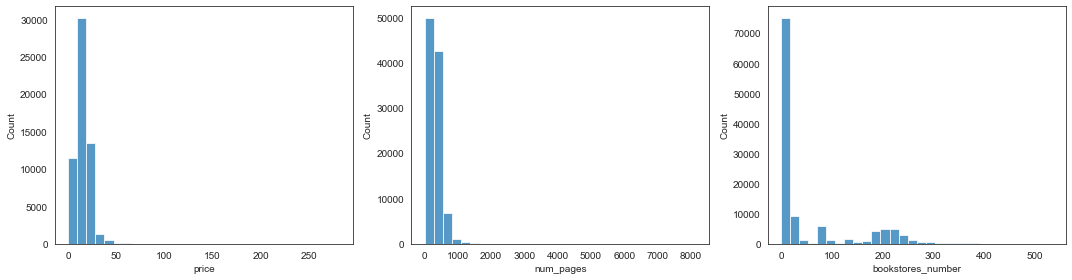

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
for col, ax in zip(quantitative_vars, axes):
    sns.histplot(quantitative_df[col], bins=30, ax=ax)

plt.tight_layout() 
plt.show();

The boxplots provide a different view into the same findings: some 'outliers' with more than 1000 pages and prices over 100€. The three distributions include only values equal or over zero.

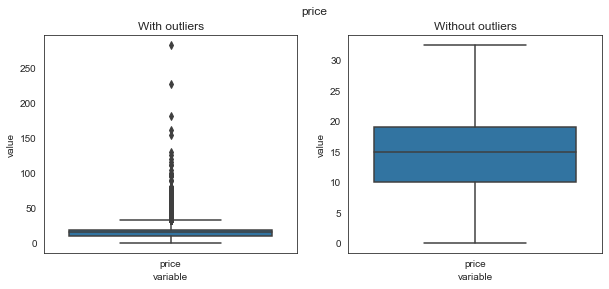

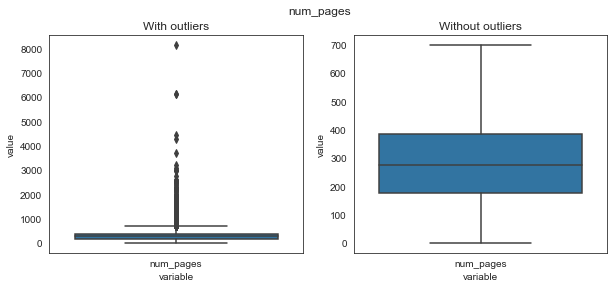

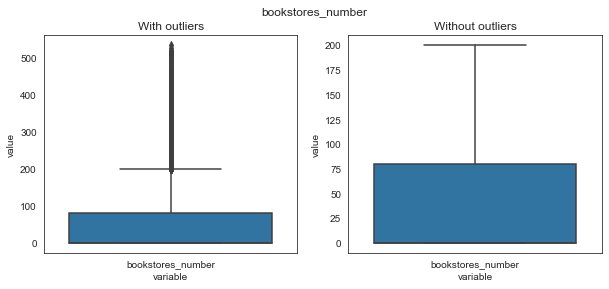

In [36]:
quant_melted = pd.melt(quantitative_df)
quant_melted.loc[:, 'value'] = pd.to_numeric(quant_melted.value)

for quant_var in quantitative_vars:
    quant_var_data = quant_melted[quant_melted['variable']==quant_var]
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.boxplot(x="variable", y="value", data=quant_var_data, ax=axes[0]).set_title('With outliers')
    sns.boxplot(x="variable", y="value", data=quant_var_data, showfliers = False, ax=axes[1]).set_title('Without outliers');
    fig.suptitle(quant_var)

##### Zoom into: bookstores number
A quick look at the distribution via the histogram or the percentiles shows that many books are available at very few shops (the 25% percentile is 2!). It is useful to take a look at the `bookstores_number` distribution removing values under the 25% percentile in order to find out that it is approximately centered around 240 bookstores, with a long tail of books available at more than 300 or even 400 shops.

It's important to notice that this variable is linked to the date when the data was retrieved. If this variable is of interest for any analysis, it might be necessary to update the data periodically in order to be able to study the distribution in time (the bookstores number time series).

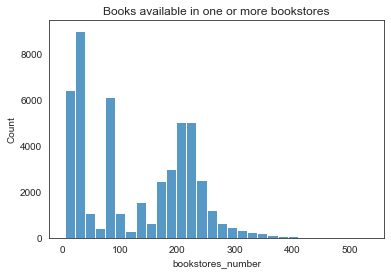

In [38]:
df_bookstores_number = df.loc[df['bookstores_number']>2, 'bookstores_number']
sns.histplot(df_bookstores_number, bins=30)
plt.title('Books available in one or more bookstores');

#### Qualitative features
Some of the categorical features, such as `title`, `author`, `img_url`, `synopsis` or `publisher`, have a great number of unique values (in the case of `title`, there could be duplicates related to different editions of the same text, such as hardcover and paperback). `isbn` and `ean`, on the other hand, are unique identifiers. 

In [39]:
qualitative_vars_df = types_df[(types_df['type']=='string') | (types_df['type']=='object')]
qualitative_vars = list(qualitative_vars_df['index'].to_numpy())
qualitative_vars

['title',
 'author',
 'publisher',
 'isbn',
 'binding',
 'publishing_country',
 'publishing_language',
 'original_language',
 'ean',
 'img_url',
 'synopsis',
 'tags']

In [40]:
qualitative_df = df[qualitative_vars]
qualitative_df.head()

,title,author,publisher,isbn,binding,publishing_country,publishing_language,original_language,ean,img_url,synopsis,tags
0,Taller de escritura creativa 30 (grupo: 09-06-...,TALLER DE ESCRITURA DE CARMEN,CCC,9788471573483,<NA>,España,Castellano,Castellano,9788471573483,<NA>,<NA>,"[Español / Castellano, Ficción moderna y conte..."
1,"DON QUIJOTE, LA ÚLTIMA AVENTURA","SANTANDER MANSO, JUAN MANUEL",978-84-938962,9788493896201,Tapa blanda o Bolsillo,España,Castellano,,9788493896201,https://static.cegal.es/imagenes/marcadas/9788...,<NA>,"[Español / Castellano, Ficción moderna y conte..."
2,El salto de Trafalgar,"Rodríguez Pérez, Ernesto",120 Pies,9788494392443,Libro electrónico,España,Castellano,,9788494392443,<NA>,<NA>,"[Ficción moderna y contemporanea, EUROPA, Aven..."
3,Gravity over pigeon,",",Comte Barcelona,9788412143720,Tapa blanda o Bolsillo,España,Chino,,9788412143720,<NA>,<NA>,"[Ficción moderna y contemporanea, China]"
4,Bingo Palace,"Erdrich, Louise",Siruela,9788418708183,Libro electrónico,España,Castellano,Inglés,9788418708183,https://static.cegal.es/imagenes/marcadas/9788...,«Bingo Palace nos muestra un lugar donde el a...,[Ficción moderna y contemporanea]


A count of the unique values by column shows us the variability of some of the columns and how those are not suitable for a categorical analysis. Some things to notice are:

- The number of different titles is less than the number of ISBN codes. This may relate to the availability of different releases or editions for certain books. A count of bindings and publishing languages or publishers per book will clarify this point (see 'Multivariate analysis').
- The number of different ISBN and EAN codes is identical. 
- There are 6520 different combinations of tags, but more than one tag may be assigned to a book. A zoom into the `tags` feature is necessary to further understand its details.
- The features that have a limited number of values and can thus be considered purely categorical are `binding`, `publishing_country`, `publishing_language` and `original_language`.

In [41]:
qualitative_df.drop(columns='tags').nunique()

title                   89074
author                  53878
publisher                8590
isbn                   117297
binding                    29
publishing_country         29
publishing_language        43
original_language          68
ean                    117297
img_url                 87638
synopsis                66109
dtype: int64

##### Purely categorical features

In [42]:
categorical_vars = ['binding', 'publishing_country', 'publishing_language', 'original_language']
categorical_df = df.loc[:, categorical_vars]
categorical_df.head()

,binding,publishing_country,publishing_language,original_language
0,<NA>,España,Castellano,Castellano
1,Tapa blanda o Bolsillo,España,Castellano,
2,Libro electrónico,España,Castellano,
3,Tapa blanda o Bolsillo,España,Chino,
4,Libro electrónico,España,Castellano,Inglés


It is noticeable that there are no NaN values as such for these features, but all of them have occurrences with the empty string, which could be considered the None value for these features.

In [43]:
for catvar in categorical_vars:
    print('******** Value counts for feature:', catvar)
    print(categorical_df[catvar].value_counts())

******** Value counts for feature: binding
Tapa blanda o Bolsillo          66932
Libro electrónico               28532
Cartoné                          8145
Libro                            2921
                                 2660
Libro en otro formato             738
Archivo de audio descargable      393
Recurso en línea                  163
CD-Audio                           69
Piel / Lujo                        32
Espiral                            16
Libro de tela                       6
Folleto                             6
Carpeta                             4
CD-ROM                              4
Disco audio                         3
Libro de cartón                     3
Película o transparencia            2
Material impreso variado            2
Producto multisoporte               2
DVD Audio                           2
Fascículo                           1
Lámina                              1
Memoria USB                         1
Tarjetas                            1
Audio  

##### Zoom into: Tags
Let's take a detailed of at the `tags` column and the individual tags frequencies.

Taking a look at the www.todostuslibros.com site lets us realize that tags are not only used for genres, but for language and a sort of subgenre specification as well. There is, for instance, a tag for "classical science fiction" and a different one for "science fiction" (presumably contemporary science fiction, although in the crawling process both have been stored and aggregated as plan "science fiction"), and some books are tagged with their original language.

In [44]:
df_tags = df.explode('tags')
df_tags.head()

,title,author,publisher,isbn,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,synopsis,tags,bookstores_number
0,Taller de escritura creativa 30 (grupo: 09-06-...,TALLER DE ESCRITURA DE CARMEN,CCC,9788471573483,NaN,<NA>,España,Castellano,Castellano,9788471573483,2011-12-01,150,<NA>,<NA>,Español / Castellano,0
0,Taller de escritura creativa 30 (grupo: 09-06-...,TALLER DE ESCRITURA DE CARMEN,CCC,9788471573483,NaN,<NA>,España,Castellano,Castellano,9788471573483,2011-12-01,150,<NA>,<NA>,Ficción moderna y contemporanea,0
1,"DON QUIJOTE, LA ÚLTIMA AVENTURA","SANTANDER MANSO, JUAN MANUEL",978-84-938962,9788493896201,NaN,Tapa blanda o Bolsillo,España,Castellano,,9788493896201,2011-10-01,244,https://static.cegal.es/imagenes/marcadas/9788...,<NA>,Español / Castellano,0
1,"DON QUIJOTE, LA ÚLTIMA AVENTURA","SANTANDER MANSO, JUAN MANUEL",978-84-938962,9788493896201,NaN,Tapa blanda o Bolsillo,España,Castellano,,9788493896201,2011-10-01,244,https://static.cegal.es/imagenes/marcadas/9788...,<NA>,Ficción moderna y contemporanea,0
2,El salto de Trafalgar,"Rodríguez Pérez, Ernesto",120 Pies,9788494392443,NaN,Libro electrónico,España,Castellano,,9788494392443,2015-07-29,<NA>,<NA>,<NA>,Ficción moderna y contemporanea,0


There are a total of 1112 unique tags, where the most common is 'Ficción moderna y contemporanea' (modern and contemporary fiction).

In [45]:
df_tags.tags.describe()

count                              169875
unique                               1112
top       Ficción moderna y contemporanea
freq                                69491
Name: tags, dtype: object

The 10 more frequent tags are these, followed by a tag wordcloud:

In [46]:
df_tags.tags.value_counts().iloc[:10]

Ficción moderna y contemporanea               69491
Narrativa romántica                           11480
Género policíaco y misterio                    9638
Narrativa romántica adulta y contemporánea     9444
Ficción histórica                              8489
Obra de misterio y suspense                    7042
Fantasía                                       6450
Español / Castellano                           6134
Ciencia Ficción                                5487
Cuentos de terror y fantasmas                  2392
Name: tags, dtype: int64

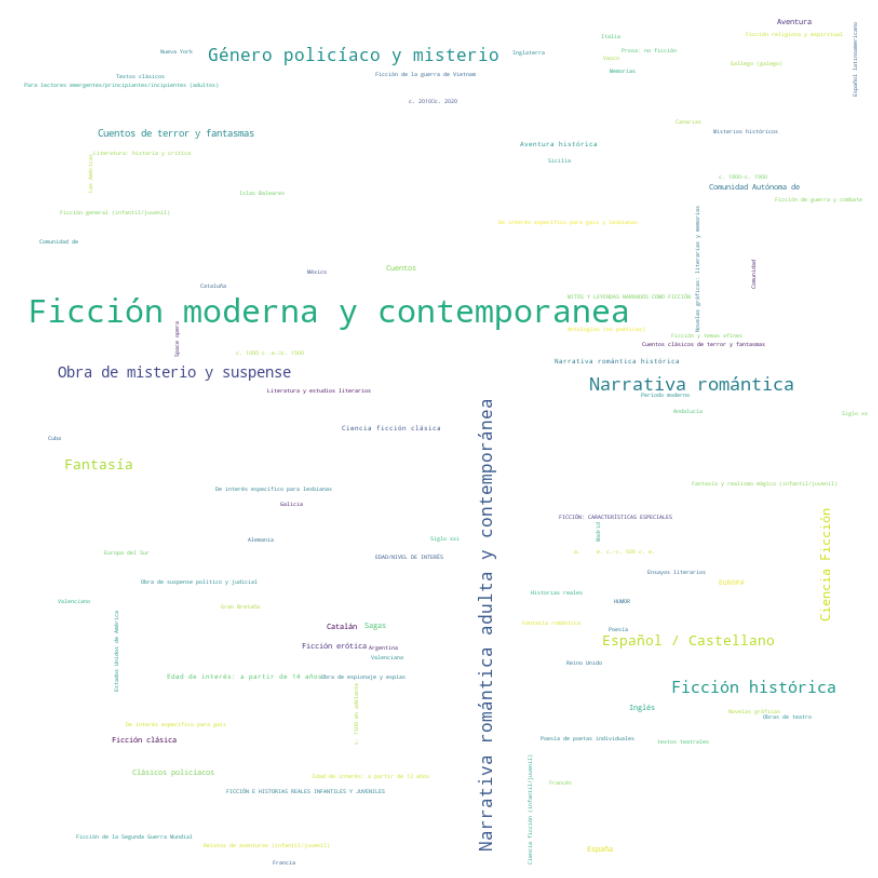

In [47]:
data = df_tags['tags'].value_counts().to_dict()
word_cloud = WordCloud(width = 800, height = 800, background_color='white', max_words=100).generate_from_frequencies(data)
plt.figure(figsize=(12, 12), facecolor = 'white', edgecolor='blue')
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(word_cloud, interpolation='bilinear')
plt.show()

#### Datetime features: publication date

`publication_date` is the only datetime feature of the dataset. 

A study of this feature may allow us to investigate the number of books published by date (month/year), from an univariate point of view. If we take into account other features we may dive into the distribution of published books per genre and date/month/year and others (see the Multivariate analysis section).

In [48]:
df_datetime = df[['publication_date']].copy()
df_datetime.loc[:, 'day_of_month'] = df_datetime.publication_date.dt.day
df_datetime.loc[:, 'month'] = df_datetime.publication_date.dt.month
df_datetime.loc[:, 'year'] = df_datetime.publication_date.dt.year
df_datetime.head()

,publication_date,day_of_month,month,year
0,2011-12-01,1.0,12.0,2011.0
1,2011-10-01,1.0,10.0,2011.0
2,2015-07-29,29.0,7.0,2015.0
3,2020-01-15,15.0,1.0,2020.0
4,2021-03-10,10.0,3.0,2021.0


A pairplot of datetime-related variables gives us some insights into the distribution of books published by month. January and October are the months with more books published. October coincides with the classical literary *rentrée* after the summer.

The concentration of publication dates around 2019 is an indicative of the general availability of just very recently published books in the bookshops. The Spanish book industry (as it's mostly the case around the globe) is one caracterized by its speed of change: a newly published book usually only lasts a few weeks on the 'new releases' shelves.

<Figure size 936x1152 with 0 Axes>

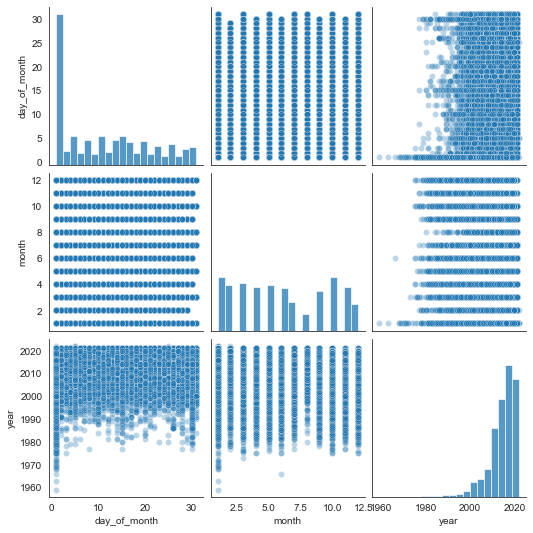

In [49]:
plt.figure(figsize=(13,16))
sns.pairplot(df_datetime, kind='scatter', diag_kind='hist', plot_kws={'alpha':0.3}, diag_kws={'bins':20});

Here is a lineplot depicting the books by date time series. Some outliers are noticeable, particularly the one around 2018:

In [50]:
df_datetime_grouped = df_datetime.groupby('publication_date').agg(published_books=pd.NamedAgg(column='day_of_month', aggfunc='count'))

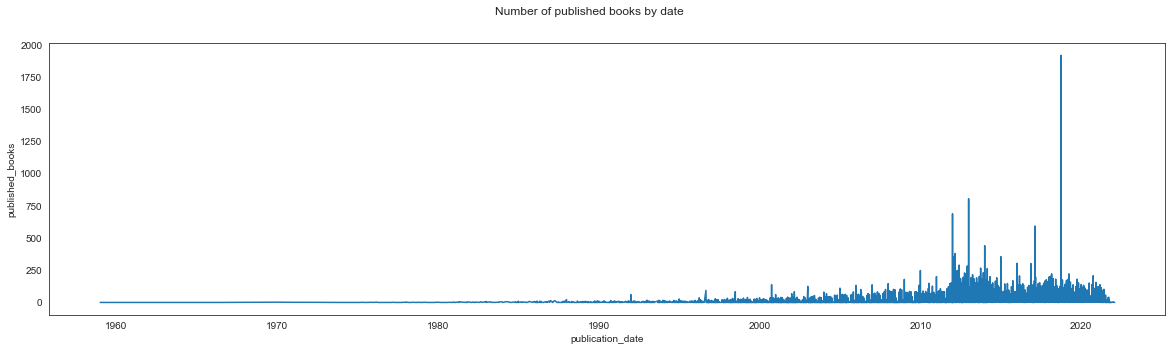

In [51]:
plt.figure(figsize=(20,5))
sns.lineplot(x='publication_date', y='published_books', data=df_datetime_grouped.reset_index())
plt.suptitle('Number of published books by date');

The following table displays the top 20 days with more published books:

In [52]:
df_datetime_grouped.reset_index().sort_values(by='published_books', ascending=False).head(10)

,publication_date,published_books
6060,2018-10-01,1919
4029,2013-01-01,806
3701,2012-01-01,689
5477,2017-02-14,594
4362,2014-01-01,442
3756,2012-03-01,381
4712,2015-01-01,357
3730,2012-02-01,357
5074,2016-01-01,305
5386,2016-11-15,303


##### Time series by publication date

The following plot studies the distribution of published books along the days of the month:

A heatmap of published books by day of the month highlights what was already visible in the pairplot: most of the books published are released on the first day of the month. The second more important date in the month is around the 15th. This heatmap also shows the relevance of January and October for the book industry, followed by March. The summer months (July and, specially, August) are particularly short of published books.

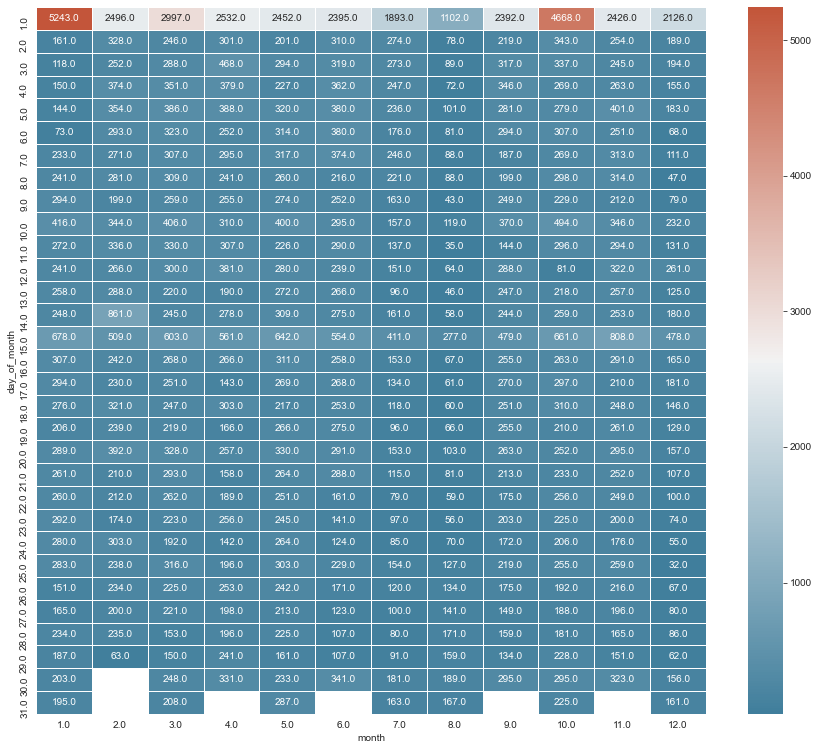

In [53]:
df_datetime_month = df_datetime.groupby(['month', 'day_of_month']).agg({'publication_date': 'count'}).reset_index()
df_datetime_pivot = df_datetime_month.pivot("day_of_month", "month", "publication_date")

cmap = sns.diverging_palette(230, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(15, 13))
sns.heatmap(df_datetime_pivot, annot=True, fmt='', linewidths=.5, ax=ax, cmap=cmap);

##### The outlier of 1919 books published on the 01/10/2018

Let's take a look at the 01/10/2018, the top date with 1919 books, to dive in the characteristics of these books:

In [54]:
df_pubdate_outlier = df.query('publication_date == "2018-10-01"')
df_pubdate_outlier.head()

,title,author,publisher,isbn,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,synopsis,tags,bookstores_number
633,Los Hijos de la Revolución Francesa,"Janeiro, Manuel",Elcercano Espacio,9788494701757,15.0,Tapa blanda o Bolsillo,España,Castellano,Castellano,9788494701757,2018-10-01,170,<NA>,<NA>,[Ficción moderna y contemporanea],133
1100,London and Its Environs,"Baedeker, Karl",Franklin Classics Trade Press,9780343908683,NaN,Tapa blanda o Bolsillo,,Inglés,,9780343908683,2018-10-01,620,https://static.cegal.es/imagenes/marcadas/9780...,This work has been selected by scholars as be...,[Ficción moderna y contemporanea],0
1101,Novels and Fairy Tales of Oscar Wilde,"Wilde , Oscar",Franklin Classics Trade Press,9780343908232,NaN,Tapa blanda o Bolsillo,,Inglés,,9780343908232,2018-10-01,786,https://static.cegal.es/imagenes/marcadas/9780...,This work has been selected by scholars as be...,[Ficción moderna y contemporanea],0
1102,Thaddeus of Warsaw,"Porter, Jane",Franklin Classics Trade Press,9780343908386,NaN,Tapa blanda o Bolsillo,,Inglés,,9780343908386,2018-10-01,258,https://static.cegal.es/imagenes/marcadas/9780...,This work has been selected by scholars as be...,[Ficción moderna y contemporanea],0
1103,Thaddeus of Warsaw,"Porter, Jane",Franklin Classics Trade Press,9780343908393,NaN,Tapa blanda o Bolsillo,,Inglés,,9780343908393,2018-10-01,258,https://static.cegal.es/imagenes/marcadas/9780...,This work has been selected by scholars as be...,[Ficción moderna y contemporanea],0


It might be a coincidence that the first few rows are books fron 'Franklin Classics Trade Press'. When checking the total count of books published on this date by publisher we discover that Franklin Classics Trade Press is the top contributor:

In [55]:
df_pubdate_outlier.groupby('publisher').count().sort_values(by='isbn', ascending=False)

,title,author,isbn,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,synopsis,tags,bookstores_number
publisher,,,,,,,,,,,,,,,
Franklin Classics Trade Press,1681,1681,1681,0,1681,1681,1681,1681,1681,1681,1681,1301,1681,1681,1681
Harlequin Ibérica,33,33,33,2,33,33,33,33,33,33,33,33,33,33,33
Grupo Editorial Círculo Rojo SL,33,33,33,1,33,33,33,33,33,33,10,1,0,33,33
Editorial LXL,10,10,10,3,10,10,10,10,10,10,10,10,9,10,10
Lulu Press,8,8,8,8,8,8,8,8,8,8,0,8,8,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ediciones Oblicuas,1,1,1,0,1,1,1,1,1,1,0,0,0,1,1
Ediciones Kiwi,1,1,1,0,1,1,1,1,1,1,1,0,0,1,1
Ediciones Contrabando,1,1,1,0,1,1,1,1,1,1,1,0,0,1,1


When checking the available books from this publisher in the complete dataset, we discover that all of them have publication date in October 2018 and, furthermore, none of the books with publication date 01/10/2018 are available in any bookstore. A further search in Google does not come up with any website for the publisher, but there is a [Reddit thread](https://www.reddit.com/r/books/comments/hjf13i/buyer_beware_franklin_classics_publishing_and/) describing the poor quality of the books and speculating about them being from an on-demand publishing company. It is possible that these books became available as a single lot distributed to several bookstores in October 2018.

In [56]:
df.query('publisher == "Franklin Classics Trade Press"').groupby('publication_date').agg({'isbn': 'count', 'bookstores_number': 'sum'}).sort_values(by='isbn', ascending=False)

,isbn,bookstores_number
publication_date,,
2018-10-01,1681,0
2018-10-18,2,46
2018-10-27,2,46
2018-10-21,1,23


Furthermore, the synopsis of all the books is exactly the same, relating to books available in the USA public domain:

In [57]:
df.query('publisher == "Franklin Classics Trade Press"').synopsis.unique()

<StringArray>
[' This work has been selected by scholars as being culturally important and is part of the knowledge base of civilization as we know it.This work is in the public domain in the United States of America, and possibly other nations. Within the United States, you may freely copy and distribute this work, as no entity (individual or corporate) has a copyright on the body of the work.Scholars believe, and we concur, that this work is important enough to be preserved, reproduced, and made generally available to the public. To ensure a quality reading experience, this work has been proofread and republished using a format that seamlessly blends the original graphical elements with text in an easy-to-read typeface.We appreciate your support of the preservation process, and thank you for being an important part of keeping this knowledge alive and relevant.', ' This is a reproduction of a book published before 1923. This book may have occasional imperfections such as missing or bl

As a conclusion, this publisher seems an anomaly in an otherwise quite regular dataset. It would probably be safe enough to remove all Franklin Classics Trade Press books from the dataset prior to starting with the analysis of any machine learning model.

#### Outliers
Let's take a look at the outliers we saw in the boxplot for numerical features via the Tukey test, in order to quantify and explore them:

In [58]:
def tukey_outliers(df,column,extreme=False):
    q1, q3 = np.percentile(df[column],[25,75])
    iqr = q3 - q1
    constant = 1.5 if not extreme else 3
    return df[~((df[column]>(q3+constant*iqr)) | (df[column]<(q1-constant*iqr)))]

In [59]:
df_tukey_price = tukey_outliers(df.dropna(), 'price', extreme=True)
print(df_tukey_price.shape)

df_tukey_num_pages = tukey_outliers(df.dropna(), 'num_pages', extreme=True)
print(df_tukey_num_pages.shape)

df_tukey_bookstores_number = tukey_outliers(df.dropna(), 'bookstores_number',extreme=True)
print(df_tukey_bookstores_number.shape)

(44444, 16)
(44216, 16)
(44538, 16)


#### Null values
In order to study the distribution of null values in the dataset, we will convert all empty strings to NA:

In [60]:
df_with_nulls = df.replace('', np.nan)
df_with_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117297 entries, 0 to 18308
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   title                117297 non-null  string        
 1   author               116244 non-null  string        
 2   publisher            117291 non-null  string        
 3   isbn                 117297 non-null  string        
 4   price                57027 non-null   float64       
 5   binding              107983 non-null  string        
 6   publishing_country   109814 non-null  string        
 7   publishing_language  117293 non-null  string        
 8   original_language    75618 non-null   string        
 9   ean                  117297 non-null  string        
 10  publication_date     115967 non-null  datetime64[ns]
 11  num_pages            100580 non-null  Int64         
 12  img_url              87638 non-null   string        
 13  synopsis       

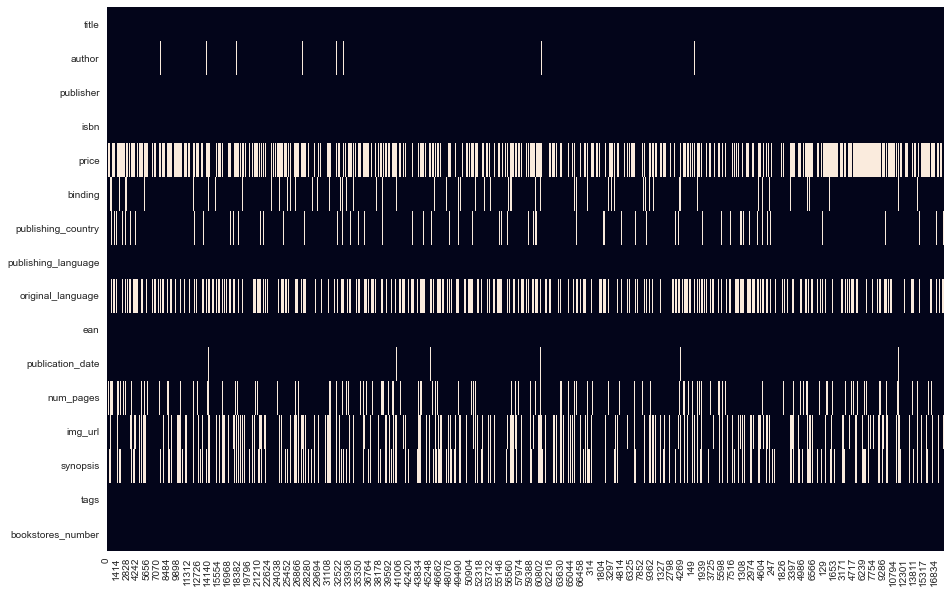

In [61]:
plt.figure(figsize=(15,10))
sns.heatmap(df_with_nulls.isnull().T, cbar=False);

Null values frequency by column:

In [63]:
df_null_count = df_with_nulls.isnull().sum().sort_values(ascending=False)
df_null_count[df_null_count>0]/df_with_nulls.shape[0]

price                  0.513824
original_language      0.355329
synopsis               0.297953
img_url                0.252854
num_pages              0.142519
binding                0.079405
publishing_country     0.063795
publication_date       0.011339
author                 0.008977
publisher              0.000051
publishing_language    0.000034
dtype: float64

Most of the books with no `price` information are not available in any bookstores. This may be a consequence of books being previously available in the platform (and in at least one bookstore) that have been sold/returned but never taken out of the catalog.

In [64]:
df[pd.isnull(df.price)].bookstores_number.value_counts()

0      51630
1       3136
80      1834
79       767
2        630
       ...  
184        1
46         1
58         1
190        1
95         1
Name: bookstores_number, Length: 83, dtype: Int64

Let's look further into books available in no bookstores. The `price` information is mostly absent, but so are other details, such as the synopsis, the book cover image or the number of pages. 

In [66]:
df_no_bookstores = df[df.bookstores_number == 0]
df_no_bookstores_null_count = df_no_bookstores.isnull().sum().sort_values(ascending=False)
df_no_bookstores_null_count[df_no_bookstores_null_count>0]/df_no_bookstores.shape[0]

price               0.869822
synopsis            0.384133
img_url             0.346850
num_pages           0.246357
binding             0.073926
publication_date    0.021227
author              0.014775
dtype: float64

### Multivariate analysis
In order to be able to study the correlation between numerical and categorical variables, we will turn the latter into dummies:

In [89]:
df_dummies = df.copy()

In [90]:
df_dummies = pd.get_dummies(df, columns=['binding'], prefix='bnd', drop_first=False)
print(df_dummies.shape)

df_dummies = pd.get_dummies(df_dummies, columns=['publishing_country'], prefix='pc', drop_first=False)
print(df_dummies.shape)

df_dummies = pd.get_dummies(df_dummies, columns=['publishing_language'], prefix='pl', drop_first=False)
print(df_dummies.shape)

df_dummies = pd.get_dummies(df_dummies, columns=['original_language'], prefix='ol', drop_first=False)
print(df_dummies.shape)

df_dummies.head()

(117297, 44)
(117297, 72)
(117297, 114)
(117297, 181)


,title,author,publisher,isbn,price,ean,publication_date,num_pages,img_url,synopsis,tags,bookstores_number,bnd_,bnd_Archivo de audio descargable,bnd_Audio,bnd_Audiocasete,bnd_CD-Audio,bnd_CD-ROM,bnd_Calendario,bnd_Carpeta,bnd_Cartoné,bnd_DVD Audio,bnd_Disco audio,bnd_Espiral,bnd_Fascículo,bnd_Folleto,bnd_Libro,bnd_Libro de cartón,bnd_Libro de tela,bnd_Libro electrónico,bnd_Libro en otro formato,bnd_Lámina,bnd_Mapa en hojas,bnd_Material impreso variado,bnd_Memoria USB,bnd_Película o transparencia,bnd_Piel / Lujo,bnd_Producto multisoporte,bnd_Recurso en línea,bnd_Tapa blanda o Bolsillo,bnd_Tarjetas,pc_,pc_Alemania,pc_Argentina,pc_Bolivia,pc_Chile,pc_China,pc_Colombia,pc_Croacia,pc_Cuba,pc_Dinamarca,pc_Ecuador,pc_España,pc_Estados Unidos de América,pc_Estonia,pc_Etiopía,pc_Francia,pc_Guatemala,pc_Italia,pc_México,pc_Paraguay,pc_Países Bajos,pc_Perú,pc_Portugal,pc_Puerto Rico,pc_Reino Unido de Gran Bretaña,pc_Singapur,pc_Suiza,pc_Uruguay,pc_Venezuela,pl_,pl_Afrikaans,pl_Alemán,pl_Aragonés,pl_Aranés,pl_Asturiano,pl_Bashkir,pl_Castellano,pl_Catalán,pl_Caucásico (Otros),pl_Chino,pl_Danés,pl_Escocés,pl_Esperanto,pl_Francés,pl_Gallego,pl_Hindi,pl_Holandés,pl_Inglés,pl_Inglés medio (1100-1500),pl_Irlandés,pl_Islandés,pl_Italiano,pl_Japonés,pl_Latín,pl_Lenguas múltiples,pl_Lenguas varias,pl_Macedonio,pl_Marathi,pl_No determinado,pl_Noruego,pl_Polish,pl_Portugués,pl_Rumano,pl_Ruso,pl_Shona,pl_Somali,pl_Sueco,pl_Tamil,pl_Turco,pl_Valenciano,pl_Vasco / Euskara,pl_Árabe,ol_,ol_Afrikaans,ol_Albanés,ol_Alemán,ol_Aragonés,ol_Aranés,ol_Asturiano,ol_Bereber (Otros),ol_Bielorruso,ol_Bosnio,ol_Búlgaro,ol_Castellano,ol_Catalán,ol_Checo,ol_Chino,ol_Coreano,ol_Croata,ol_Danés,ol_Egipcio,ol_Escocés,ol_Eslavo,ol_Eslovaco,ol_Esloveno,ol_Esperanto,ol_Estonio,ol_Finlandés,ol_Francés,ol_Gallego,ol_Griego antiguo (hasta 1453),ol_Griego moderno (1453-),ol_Hebreo,ol_Hindi,ol_Holandés,ol_Holandés medio (ca. 1050-1350),ol_Húngaro,ol_Inglés,ol_Inglés antiguo (ca. 450-1100),ol_Inglés medio (1100-1500),ol_Iraní (Otros),ol_Irlandés,ol_Islandés,ol_Italiano,ol_Japonés,ol_Javanese,ol_Kurdo,ol_Latín,ol_Lenguas múltiples,ol_Lenguas varias,ol_Letón,ol_Lituano,ol_No determinado,ol_Noruego,ol_Noruego nynorsk,ol_Occitano,ol_Persa,ol_Polish,ol_Portugués,ol_Rumano,ol_Ruso,ol_Serbio,ol_Sueco,ol_Turco,ol_Ucraniano,ol_Urdu,ol_Valenciano,ol_Vasco / Euskara,ol_Yiddish,ol_Árabe
0,Taller de escritura creativa 30 (grupo: 09-06-2011),TALLER DE ESCRITURA DE CARMEN,CCC,9788471573483,NaN,9788471573483,2011-12-01,150,<NA>,<NA>,"[Español / Castellano, Ficción moderna y contemporanea]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"DON QUIJOTE, LA ÚLTIMA AVENTURA","SANTANDER MANSO, JUAN MANUEL",978-84-938962,9788493896201,NaN,9788493896201,2011-10-01,244,https://static.cegal.es/imagenes/marcadas/9788493/978849389620.gif,<NA>,"[Español / Castellano, Ficción moderna y contemporanea]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,El salto de Trafalgar,"Rodríguez Pérez, Ernesto",120 Pies,9788494392443,NaN,9788494392443,2015-07-29,<NA>,<NA>,<NA>,"[Ficción moderna y contemporanea, EUROPA, Aventura, Ciencia Ficción]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [91]:
list(df_dummies.columns)

['title',
 'author',
 'publisher',
 'isbn',
 'price',
 'ean',
 'publication_date',
 'num_pages',
 'img_url',
 'synopsis',
 'tags',
 'bookstores_number',
 'bnd_',
 'bnd_Archivo de audio descargable',
 'bnd_Audio',
 'bnd_Audiocasete',
 'bnd_CD-Audio',
 'bnd_CD-ROM',
 'bnd_Calendario',
 'bnd_Carpeta',
 'bnd_Cartoné',
 'bnd_DVD Audio',
 'bnd_Disco audio',
 'bnd_Espiral',
 'bnd_Fascículo',
 'bnd_Folleto',
 'bnd_Libro',
 'bnd_Libro de cartón',
 'bnd_Libro de tela',
 'bnd_Libro electrónico',
 'bnd_Libro en otro formato',
 'bnd_Lámina',
 'bnd_Mapa en hojas',
 'bnd_Material impreso variado',
 'bnd_Memoria USB',
 'bnd_Película o transparencia',
 'bnd_Piel / Lujo',
 'bnd_Producto multisoporte',
 'bnd_Recurso en línea',
 'bnd_Tapa blanda o Bolsillo',
 'bnd_Tarjetas',
 'pc_',
 'pc_Alemania',
 'pc_Argentina',
 'pc_Bolivia',
 'pc_Chile',
 'pc_China',
 'pc_Colombia',
 'pc_Croacia',
 'pc_Cuba',
 'pc_Dinamarca',
 'pc_Ecuador',
 'pc_España',
 'pc_Estados Unidos de América',
 'pc_Estonia',
 'pc_Etiopía',


Correlation matrix and plot:

In [92]:
corr_matrix = df_dummies.corr()

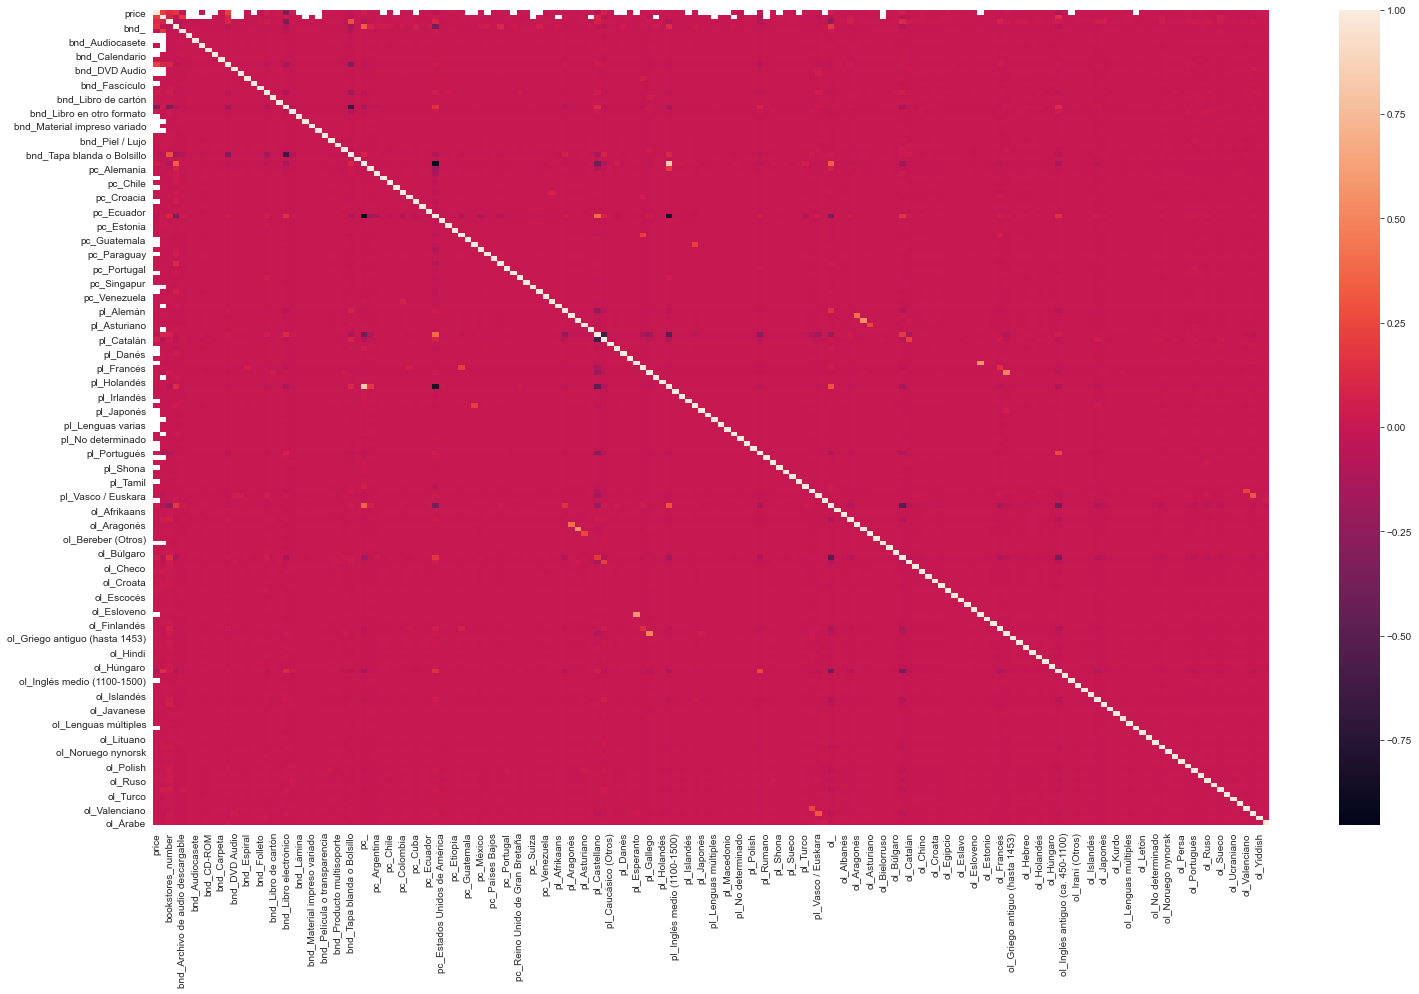

In [93]:
plt.figure(figsize=(25,15))
sns.heatmap(corr_matrix);

Looking at the highest correlations in the matrix, some interesting things arise:

- The empty publication country is very highly correlated with Spain as publication country or with English as publication language. This is the top correlation of the matrix.
- Spain as publication country is highly correlated with English as publication language. Is this a contradiction or a fault in the data?
- E-book and paperback are correlated (0.66). May this mean that most paperbacks are also published as E-books?
- Spanish and Catalonian publication languages are correlated.
- Publication and original languages are correlated for Esperanto and Aranés (local dialect from the Pyrenees). We may later check how many books in aranés are available in the dataset, as is a minoritary dialect. This looks like a spurious correlation.
- The empty original language is correlated with Spanish as original language. 

If we take into account the usual recommendation of dropping one variable of a pair with more than 85% correlation, the only pair to drop is the only that relates the null publication country with Spain as publication country:


In [94]:
corr_abs = corr_matrix.abs()
sol = (corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))
sol[sol>0.5]

pc_                    pc_España                     0.954600
pc_España              pl_Inglés                     0.824780
pc_                    pl_Inglés                     0.822232
bnd_Libro electrónico  bnd_Tapa blanda o Bolsillo    0.653578
pl_Castellano          pl_Catalán                    0.598644
pl_Esperanto           ol_Esperanto                  0.577345
pl_Aranés              ol_Aranés                     0.552002
ol_                    ol_Castellano                 0.502082
dtype: float64

## Cleaning operations
Finally, after performing the exploratory analysis, let's clean the dataset doing the following:

- Remove pc_ (null publication country column), one of the highly correlated pair [pc, pc_España].
- Rename a few columns for clarity: all dummy columns related to None values (type_ to type_None).
- Remove books by 'Franklin Classics Trade Press'.

We will generate 2 files: one with all the dummies, to be used in potential ML models, and another one without dummies, to be used in a Flask app that displays some basic insights from the data.


### Dummy file

In [120]:
df_dummy_clean = df_dummies.drop(columns=['pc_'])

In [121]:
df_dummy_clean.rename(columns={'bnd_' : 'bnd_None', 'pl_' : 'pl_None', 'ol_' : 'ol_None', }, inplace=True)

In [122]:
df_dummy_clean_final = df_dummy_clean[df_dummy_clean['publisher']!='Franklin Classics Trade Press']
df_dummy_clean_final.shape

(115611, 180)

In [123]:
df_dummy_clean_final.dtypes

title                                        string
author                                       string
publisher                                    string
isbn                                         string
price                                       float64
ean                                          string
publication_date                     datetime64[ns]
num_pages                                     Int64
img_url                                      string
synopsis                                     string
tags                                         object
bookstores_number                             Int64
bnd_None                                      uint8
bnd_Archivo de audio descargable              uint8
bnd_Audio                                     uint8
bnd_Audiocasete                               uint8
bnd_CD-Audio                                  uint8
bnd_CD-ROM                                    uint8
bnd_Calendario                                uint8
bnd_Carpeta 

### Standard file

In [132]:
df_with_nulls.shape

(117297, 16)

In [133]:
df_standard_clean = df_with_nulls[df_with_nulls['publisher']!='Franklin Classics Trade Press']
df_standard_clean.shape

(115605, 16)

In [135]:
df_standard_clean.head()

,title,author,publisher,isbn,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,synopsis,tags,bookstores_number
0,Taller de escritura creativa 30 (grupo: 09-06-2011),TALLER DE ESCRITURA DE CARMEN,CCC,9788471573483,NaN,<NA>,España,Castellano,Castellano,9788471573483,2011-12-01,150,<NA>,<NA>,"[Español / Castellano, Ficción moderna y contemporanea]",0
1,"DON QUIJOTE, LA ÚLTIMA AVENTURA","SANTANDER MANSO, JUAN MANUEL",978-84-938962,9788493896201,NaN,Tapa blanda o Bolsillo,España,Castellano,<NA>,9788493896201,2011-10-01,244,https://static.cegal.es/imagenes/marcadas/9788493/978849389620.gif,<NA>,"[Español / Castellano, Ficción moderna y contemporanea]",0
2,El salto de Trafalgar,"Rodríguez Pérez, Ernesto",120 Pies,9788494392443,NaN,Libro electrónico,España,Castellano,<NA>,9788494392443,2015-07-29,<NA>,<NA>,<NA>,"[Ficción moderna y contemporanea, EUROPA, Aventura, Ciencia Ficción]",0
3,Gravity over pigeon,",",Comte Barcelona,9788412143720,NaN,Tapa blanda o Bolsillo,España,Chino,<NA>,9788412143720,2020-01-15,222,<NA>,<NA>,"[Ficción moderna y contemporanea, China]",10
4,Bingo Palace,"Erdrich, Louise",Siruela,9788418708183,NaN,Libro electrónico,España,Castellano,Inglés,9788418708183,2021-03-10,<NA>,https://static.cegal.es/imagenes/marcadas/9788418/978841870818.gif,"«Bingo Palace nos muestra un lugar donde el amor, el destino y la casualidad están tan entrelazados como los cabellos de una trenza.» The New York Times De la ganadora del National Book Award Louise Erdrich, Bingo Palace cuenta la historia del joven Liphsa Morrissey cuya vida da un vuelco cuando su abuela le suplica que vuelva a la reserva india. Allí se enamorará perdidamente de la hermosa Shawnee Ray, que está decidiendo si acepta o no la proposición de matrimonio del rico empresario y padre de su hijo Lyman Lamartine, el jefe de Liphsa en el casino Bingo Palace. Las complicaciones continúan cuando Liphsa descubre que Lyman es su rival en muchos más aspectos pues, tras aliarse con un grupo influyente de agresivos hombres de negocios, ha decidido abrir un nuevo casino dentro del territorio de la reserva, un proyecto que amenaza con destruir los lazos fundamentales que unen a la comunidad india con su pasado. Bingo Palace es un luminoso relato acerca de la muerte y la resurrección espirituales, una reflexión sobre el dinero, el amor desesperado y la esperanza inquebrantable, sobre el poder inagotable de los sueños más preciados",[Ficción moderna y contemporanea],0


In [137]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115605 entries, 0 to 18308
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   title                115605 non-null  string        
 1   author               114553 non-null  string        
 2   publisher            115605 non-null  string        
 3   isbn                 115605 non-null  string        
 4   price                57022 non-null   float64       
 5   binding              106292 non-null  string        
 6   publishing_country   109803 non-null  string        
 7   publishing_language  115601 non-null  string        
 8   original_language    75617 non-null   string        
 9   ean                  115605 non-null  string        
 10  publication_date     114278 non-null  datetime64[ns]
 11  num_pages            98894 non-null   Int64         
 12  img_url              86327 non-null   string        
 13  synopsis       

## Save the cleaned data
Save the data as a compressed parquet file to optimize space.

In [117]:
df_dummy_clean_final.to_parquet('../data/todostuslibros_dummy_clean.gzip', index = False, compression='gzip') 

In [ ]:
df_standard_clean.to_parquet('../data/todostuslibros_standard_clean.gzip', index = False, compression='gzip') 